In [325]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [ ]:
class SnakeGame:
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    def reset(self):
        self.snake = [(self.grid_size // 2, self.grid_size // 2)]
        self.direction = (0, 1)  # Mover a la derecha inicialmente
        self.food = self.generate_food()
        self.game_over = False
        self.score = 0
        self.moves_without_food = 0  # Contador de movimientos sin comer
        return self.get_state()

    def generate_food(self):
        while True:
            food = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if food not in self.snake:
                return food

    def step(self, action):
        if self.game_over:
            return self.get_state(), 0, True

        # Mover la serpiente
        if action == 0:  # Arriba
            self.direction = (-1, 0)
        elif action == 1:  # Derecha
            self.direction = (0, 1)
        elif action == 2:  # Abajo
            self.direction = (1, 0)
        elif action == 3:  # Izquierda
            self.direction = (0, -1)

        head_x, head_y = self.snake[0]
        new_head = (head_x + self.direction[0], head_y + self.direction[1])

        # Comprobar colisiones
        if (new_head in self.snake or
            new_head[0] < 0 or new_head[0] >= self.grid_size or
            new_head[1] < 0 or new_head[1] >= self.grid_size):
            self.game_over = True
            return self.get_state(), -10, True  # Penalización por colisión

        # Comer comida
        self.snake = [new_head] + self.snake
        if new_head == self.food:
            self.score += 1
            self.food = self.generate_food()  # Generar nueva comida
            self.moves_without_food = 0  # Reiniciar el contador de movimientos sin comer
            return self.get_state(), 10, False  # Recompensa por comer comida

        # No comer comida, mover la serpiente
        self.snake = self.snake[:-1]
        self.moves_without_food += 1  # Incrementar el contador de movimientos sin comer

        # Penalización si pasan 18 movimientos sin comer
        if self.moves_without_food >= 18:
            reward = -5
            self.moves_without_food = 0  # Reiniciar el contador de movimientos sin comer
        else:
            reward = 0

        # Finalizar el juego si pasan 90 movimientos sin comer
        if self.moves_without_food >= 90:
            self.game_over = True
            return self.get_state(), -10, True  # Penalización de pérdida por no comer en 90 movimientos

        return self.get_state(), reward, False  # Recompensa neutra si no hay penalización

    def get_state(self):
        return (self.snake[0], self.food, self.direction)

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        for x, y in self.snake:
            grid[x, y] = 1  # Representar la serpiente
        x, y = self.food
        grid[x, y] = 2  # Representar la comida
        plt.imshow(grid, cmap='gray')
        plt.show()

In [327]:

class QLearningAgent:
    def __init__(self, action_space,state_space, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.995):
        self.action_space = action_space
        self.state_space = state_space
        self.alpha = alpha  # Tasa de aprendizaje
        self.gamma = gamma  # Factor de descuento
        self.epsilon = epsilon  # Exploración vs explotación
        self.epsilon_min = epsilon_min  # Valor mínimo de epsilon
        self.epsilon_decay = epsilon_decay  # Tasa de decaimiento
        self.q_table = {}

    def get_q(self, state, action):
        if (state, action) not in self.q_table:
            self.q_table[(state, action)] = 0  # Inicializar con 0
        return self.q_table[(state, action)]

    def update_q(self, state, action, reward, next_state, done):
        max_future_q = max([self.get_q(next_state, a) for a in range(self.action_space)]) if not done else 0
        current_q = self.get_q(state, action)
        new_q = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)
        self.q_table[(state, action)] = new_q

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(self.action_space))  # Exploración
        else:
            q_values = [self.get_q(state, a) for a in range(self.action_space)]
            return np.argmax(q_values)  # Explotación

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [328]:
# Visualización del juego entrenado
def play_game(agent):
    env = SnakeGame()
    state = env.reset()
    done = False
    while not done:
        env.render()
        action = agent.choose_action(state)
        state, reward, done = env.step(action)
        time.sleep(0.1)


In [329]:
grid_size = 10
episodes = 100000
env = SnakeGame(grid_size)

# Configuración de los tres agentes
agents = [
    {"action_space":4,"state_space":grid_size**2 ,"name": "Agente Balanceado", "alpha": 0.1, "gamma": 0.9, "epsilon_decay": 0.9995},
    {"action_space":4,"state_space":grid_size**2 ,"name": "Agente Conservador", "alpha": 0.05, "gamma": 0.95, "epsilon_decay": 0.99995},
    {"action_space":4,"state_space":grid_size**2 ,"name": "Agente Random", "alpha": 0.5, "gamma": 0.5, "epsilon_decay": 1},
]

In [330]:
# Crear instancias de los agentes
agent_objects = []
for agent_config in agents:
    agent = QLearningAgent(
        action_space=agent_config["action_space"],
        state_space=agent_config["state_space"],
        alpha=agent_config["alpha"],
        gamma=agent_config["gamma"],
    )
    agent_objects.append({
        "name": agent_config["name"],
        "agent": agent,
        "epsilon_decay": agent_config["epsilon_decay"]
    })


In [331]:
for episode in range(episodes):
    state = env.reset()
    total_rewards = {agent["name"]: 0 for agent in agents}
    done = False

    while not done:
        # Para cada agente, elegir una acción y actualizar la tabla Q
        for agent_info in agent_objects:
            agent = agent_info["agent"]
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.update_q(state, action, reward, next_state, done)
            total_rewards[agent_info["name"]] += reward
            state = next_state

        # Reducir el valor de epsilon para cada agente después de cada episodio
        for agent_info in agent_objects:
            agent_info["agent"].decay_epsilon()

    # Guardar recompensas para cada agente después de cada episodio
    for agent_info in agent_objects:
        if "rewards" not in agent_info:
            agent_info["rewards"] = []  # Si no existe, inicializa la lista
        agent_info["rewards"].append(total_rewards[agent_info["name"]])

    if episode % 10000 == 0:
        print(f"Episode {episode}, Rewards: {total_rewards}")

Episode 0, Rewards: {'Agente Balanceado': -5, 'Agente Conservador': -5, 'Agente Random': -15}
Episode 10000, Rewards: {'Agente Balanceado': -10, 'Agente Conservador': 0, 'Agente Random': 0}
Episode 20000, Rewards: {'Agente Balanceado': 0, 'Agente Conservador': 0, 'Agente Random': 0}
Episode 30000, Rewards: {'Agente Balanceado': -30, 'Agente Conservador': -20, 'Agente Random': -40}
Episode 40000, Rewards: {'Agente Balanceado': -5, 'Agente Conservador': -5, 'Agente Random': -15}
Episode 50000, Rewards: {'Agente Balanceado': 0, 'Agente Conservador': 0, 'Agente Random': 0}
Episode 60000, Rewards: {'Agente Balanceado': -10, 'Agente Conservador': 0, 'Agente Random': 10}
Episode 70000, Rewards: {'Agente Balanceado': 0, 'Agente Conservador': -10, 'Agente Random': 30}
Episode 80000, Rewards: {'Agente Balanceado': 10, 'Agente Conservador': -10, 'Agente Random': 0}
Episode 90000, Rewards: {'Agente Balanceado': -10, 'Agente Conservador': 10, 'Agente Random': 15}


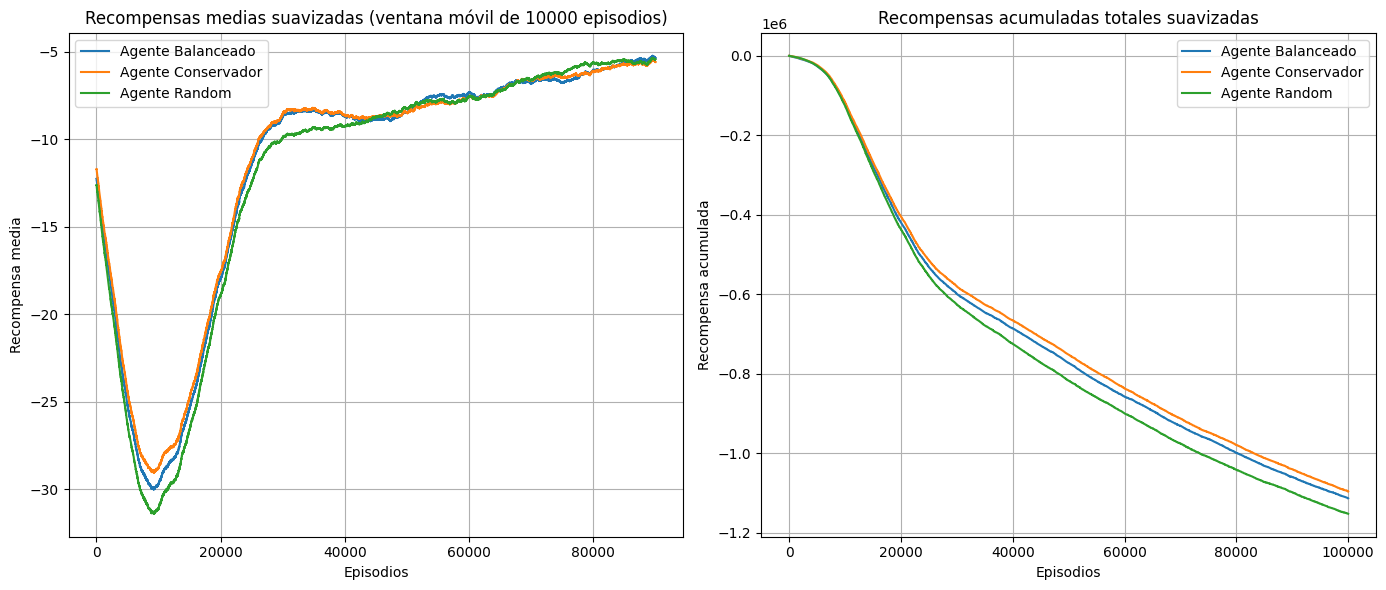

In [332]:
# Función para suavizar recompensas
def smooth(data, window_size=10000):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
# Graficar resultados suavizados
plt.figure(figsize=(14, 6))

# Gráfico de recompensas medias suavizadas
plt.subplot(1, 2, 1)
for agent_info in agent_objects:
    smoothed_rewards = smooth(agent_info["rewards"])
    plt.plot(smoothed_rewards, label=agent_info["name"])
plt.title("Recompensas medias suavizadas (ventana móvil de 10000 episodios)")
plt.xlabel("Episodios")
plt.ylabel("Recompensa media")
plt.legend()
plt.grid()

# Gráfico de recompensas acumuladas totales
plt.subplot(1, 2, 2)
for agent_info in agent_objects:
    total_rewards = np.cumsum(agent_info["rewards"])
    plt.plot(total_rewards, label=agent_info["name"])
plt.title("Recompensas acumuladas totales suavizadas")
plt.xlabel("Episodios")
plt.ylabel("Recompensa acumulada")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

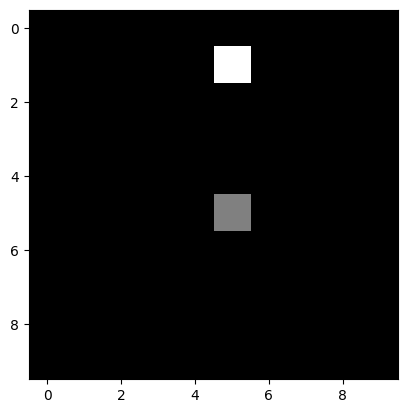

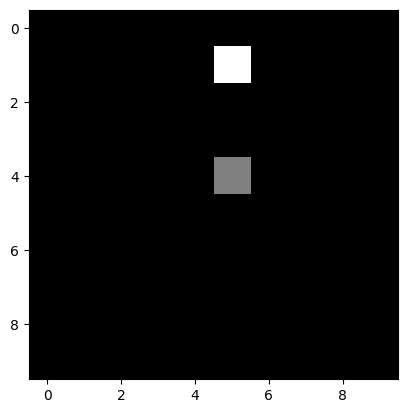

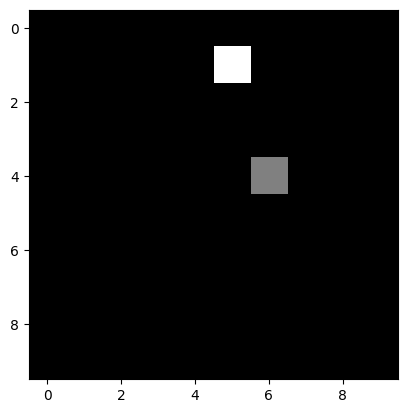

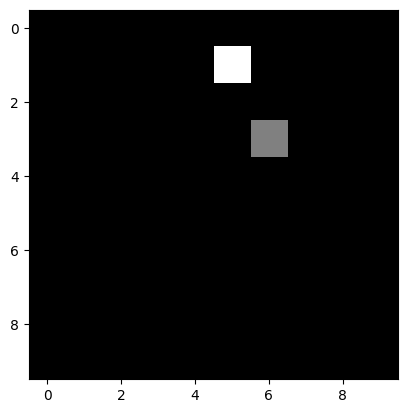

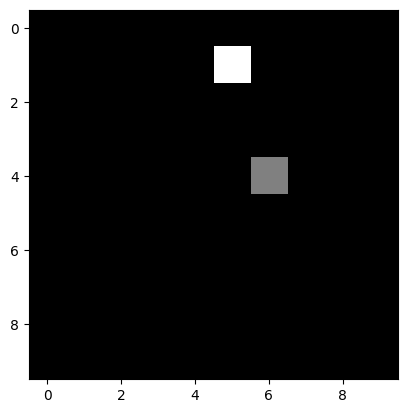

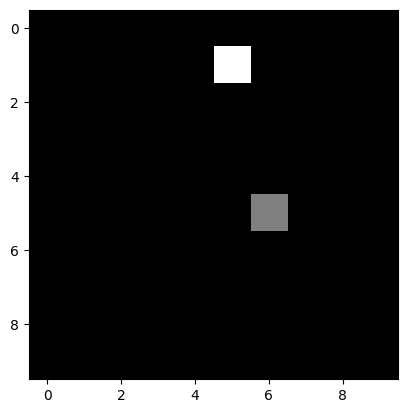

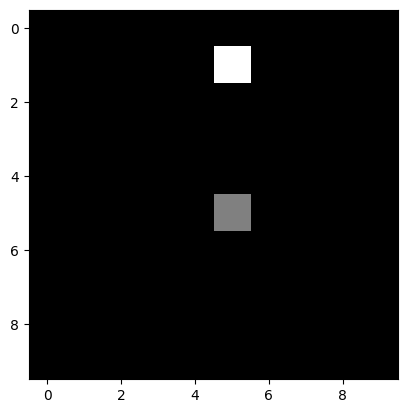

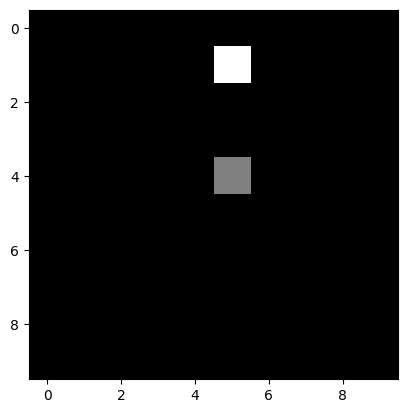

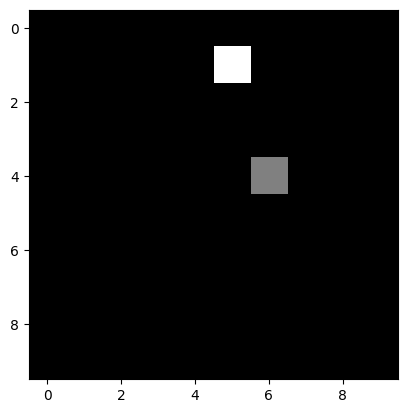

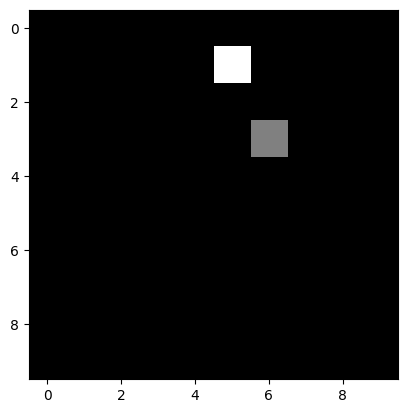

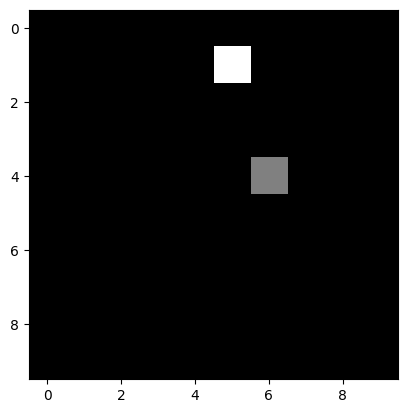

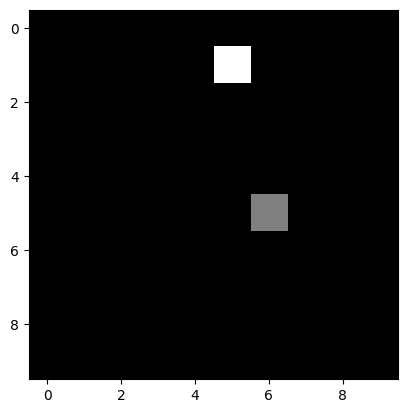

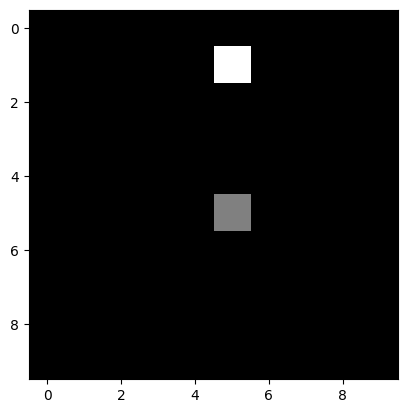

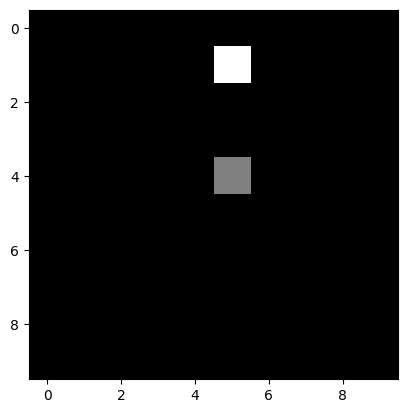

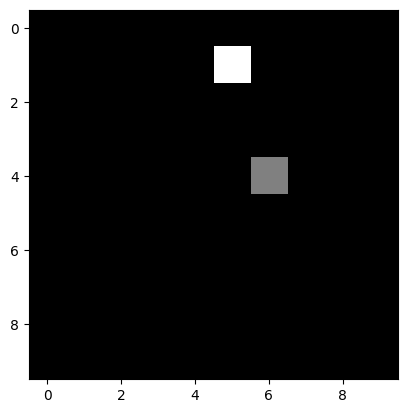

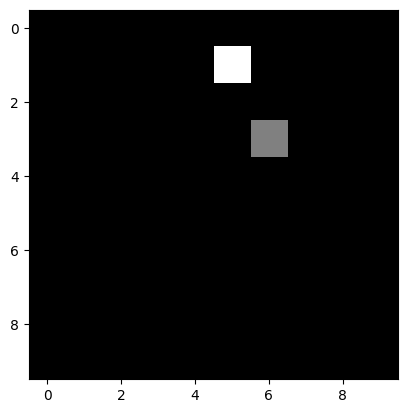

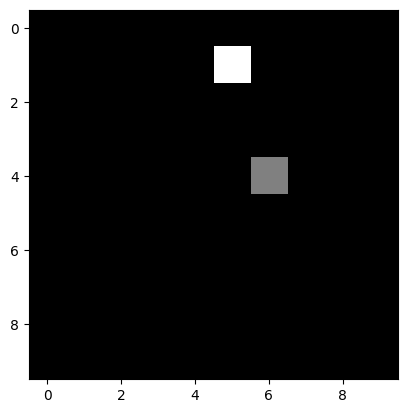

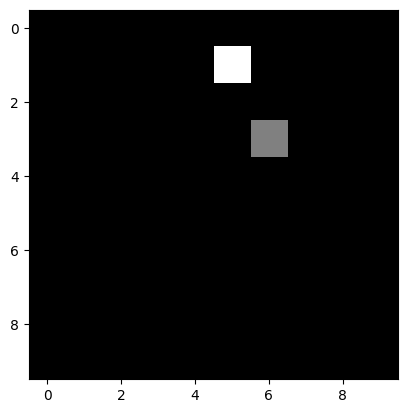

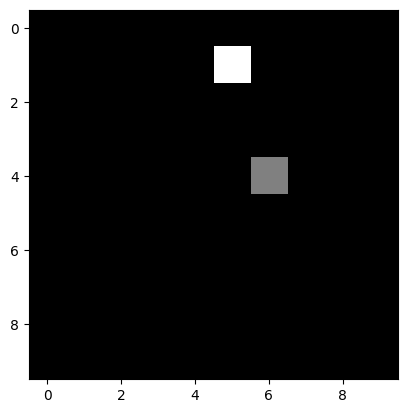

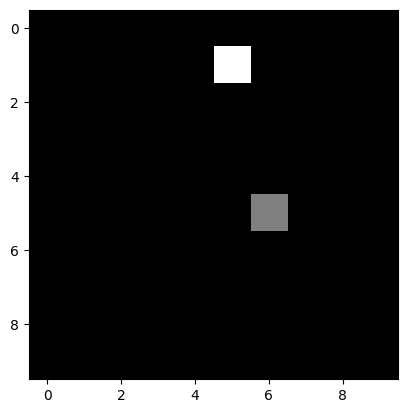

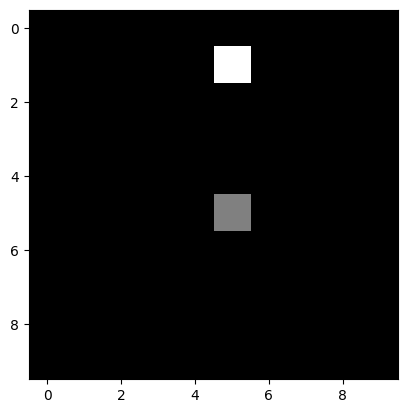

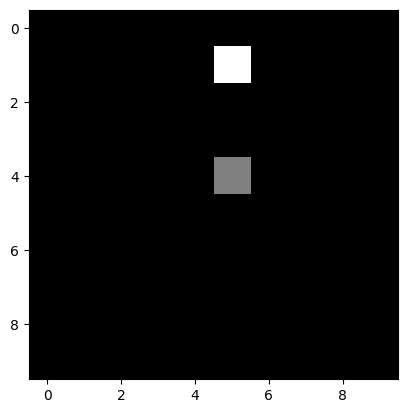

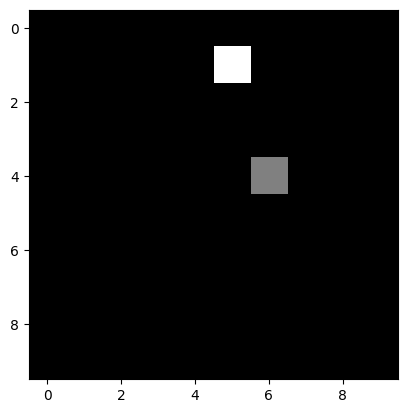

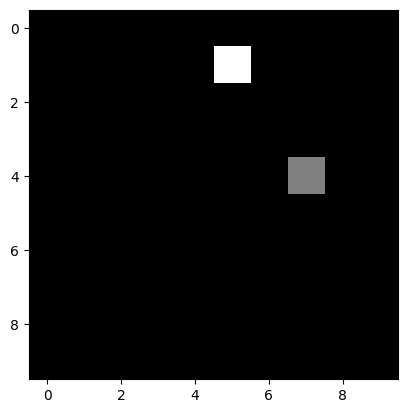

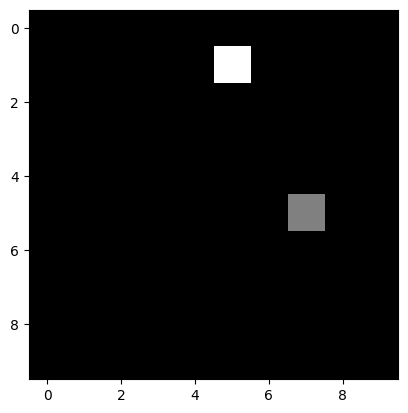

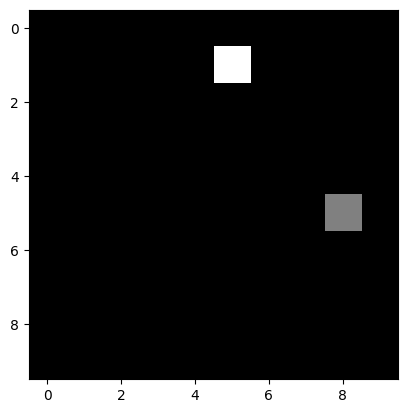

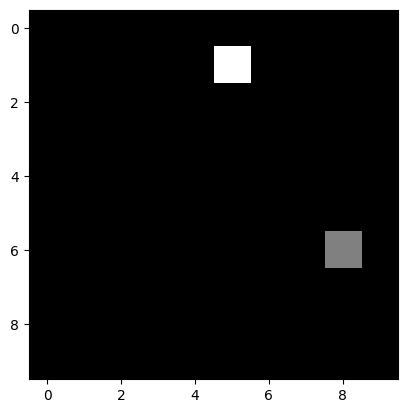

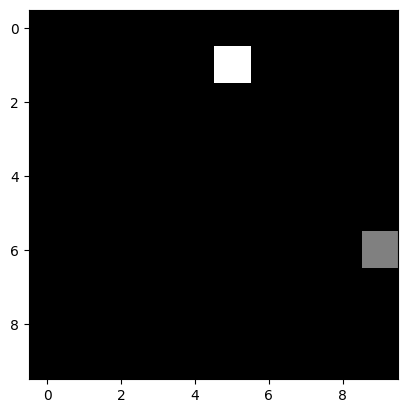

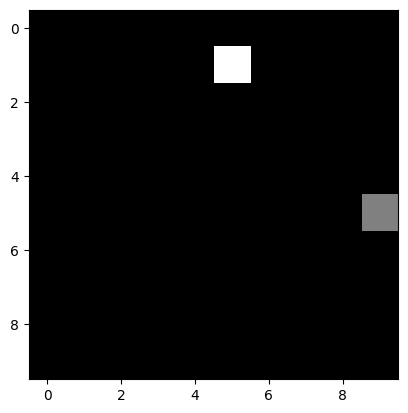

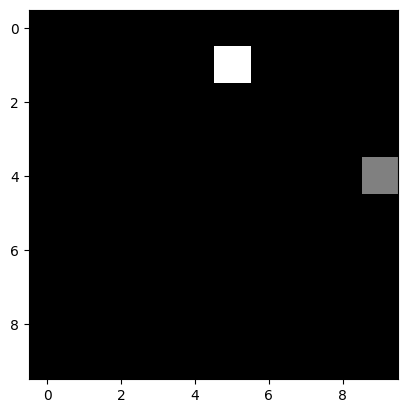

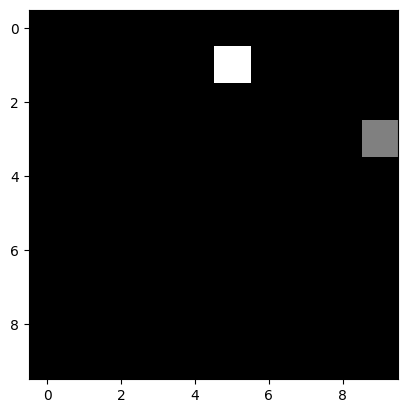

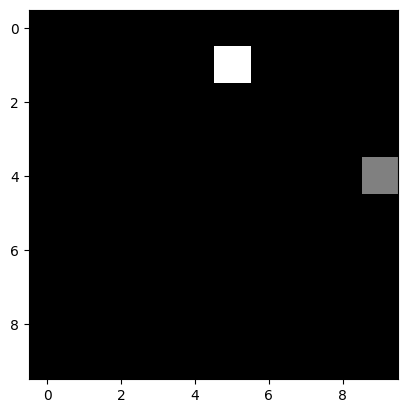

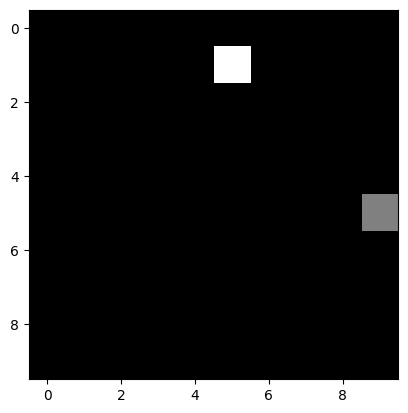

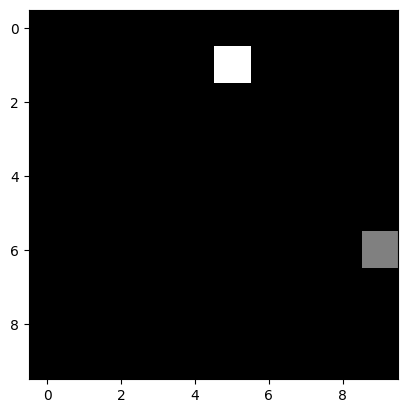

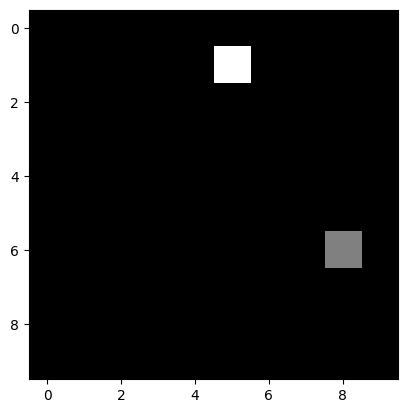

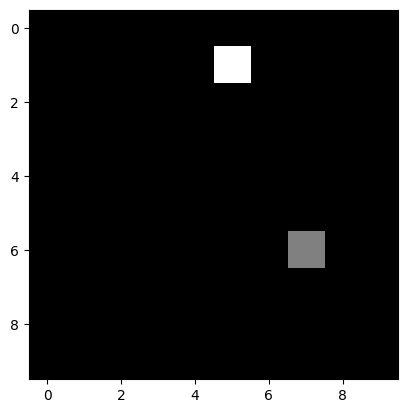

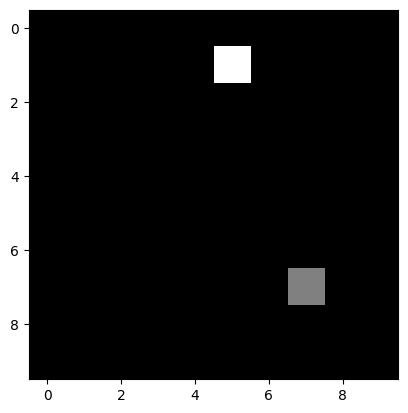

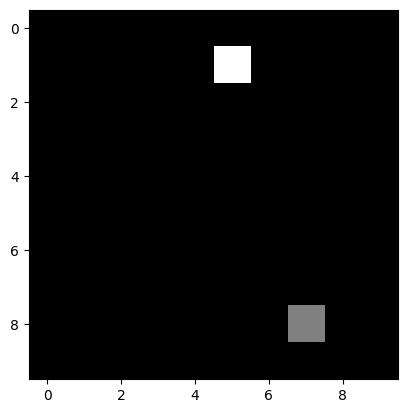

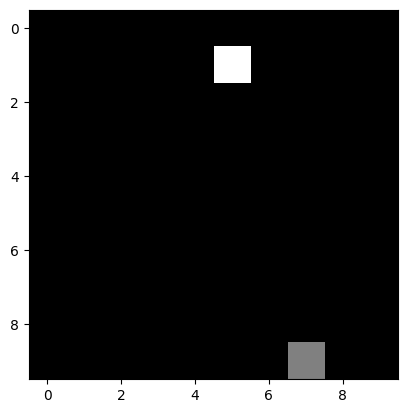

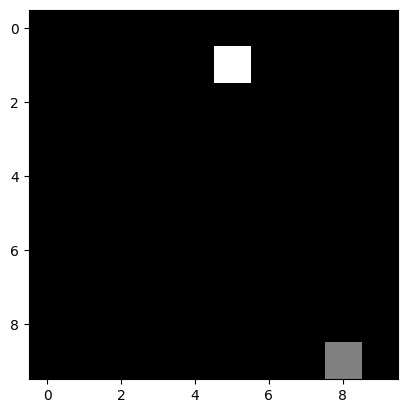

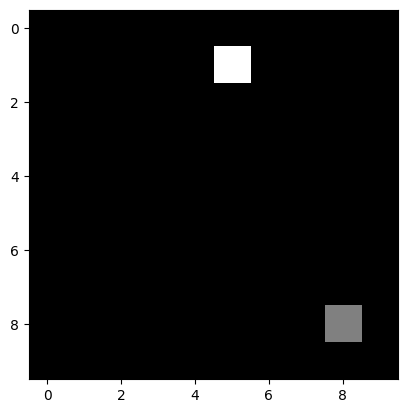

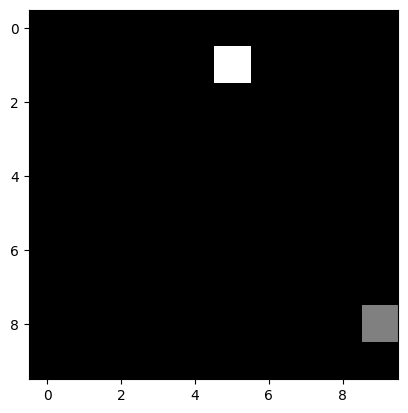

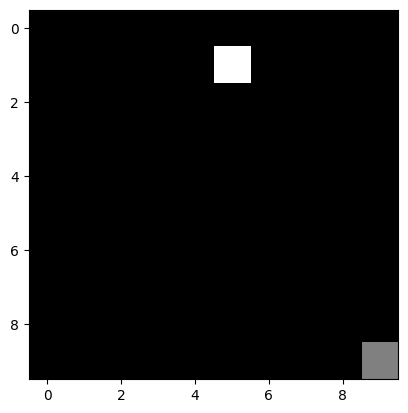

In [333]:
agent_to_play = agent_objects[2]["agent"]
play_game(agent_to_play)